# Notebook 03 - PARTE 1: Limpieza y Tratamiento de Missing Values


## Índice (Parte 1)
1. [Objetivo](#objetivo)
2. [Carga de Datos](#carga)
3. [Identificación de Valores Imposibles](#valores-imposibles)
4. [Reemplazo de Ceros por NaN](#reemplazo)
5. [Análisis de Patrones de Missing](#patron-missing)
6. [Estrategias de Imputación](#imputacion)
   - 6.1 [Imputación por Media/Mediana](#media-mediana)
   - 6.2 [Imputación por KNN](#knn)
   - 6.3 [Comparación de Métodos](#comparacion)
7. [Validación de Imputación](#validacion)
8. [Guardar Datos Limpios](#guardar)

**NOTA:** Este notebook se divide en 2 partes:
- **PARTE 1 (este archivo):** Limpieza y missing values
- **PARTE 2 (siguiente archivo):** Transformaciones, normalización y splits


**¿Qué haremos en esta parte?**
- Correguir el problema crítico identificado en EDA: **ceros imposibles**
- Decidir estrategia de imputación óptima
- Implementar imputación con múltiples métodos
- Comparar resultados y elejir mejor enfoque
- Preparar dataset limpio para transformaciones

**Recordatorio del EDA:**
- Insulin: 48.7% ceros (CRITÍCO)
- SkinThickness: 29.6% ceros
- BloodPressure: 4.6% ceros
- BMI: 1.4% ceros
- Glucose: 0.6% ceros

**Decisión clave:** ¿Imputar o eliminar?
- Eliminar -> perdemos ~50% de datos (inaceptable)
- Imputar -> mantenemos información, introducimos estimaciones

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Imputación
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer # Necesario para IterativeImputer
from sklearn.impute import IterativeImputer

# Estadística
from scipy import stats

# Utilidades 
import warnings
from pathlib import Path
import copy

# Configuarción
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

# Estilo visual
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = 11

#Crear directorios
FIGURES_DIR = Path('../reports/figures')
DATA_PROCESSED = Path('../data/processed')
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

print("Librerías importadas correctamente!")
print(f"Directorios creados: {FIGURES_DIR}, {DATA_PROCESSED}")

Librerías importadas correctamente!
Directorios creados: ..\reports\figures, ..\data\processed


In [2]:
# CARGA DEL DATASET ORIGINAL
df_original = pd.read_csv('../data/raw/diabetes.csv')

print("=" * 80)
print("DATASET ORIGINAL CARGADO")
print("=" * 80)
print(f'\nDimenciones: {df_original.shape[0]} filas x {df_original.shape[1]} columnas')

# Crear copia para trabajar (matener original intacto)
df = df_original.copy()

# Separar features y target 
features_cols = [col for col in df.columns if col != 'Outcome']
target_col = 'Outcome'

print(f'Features: {len(features_cols)}')
print(f'Target: {target_col}')

display(df.head())

DATASET ORIGINAL CARGADO

Dimenciones: 768 filas x 9 columnas
Features: 8
Target: Outcome


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Identificación de Valores Imposibles {#valores-imposibles}

ANÁLIS DETALLADO DE VALORES CERO (BIOLÓGICAMENTE IMPOSIBLES)


,Variable,Ceros,% Ceros,Min (sin ceros),Media (sin ceros),Mediana (sin ceros)
3,Insulin,374,48.697917,14.000000,155.548223,125.000000
2,SkinThickness,227,29.557292,7.000000,29.153420,29.000000
1,BloodPressure,35,4.557292,24.000000,72.405184,72.000000
4,BMI,11,1.432292,18.200000,32.457464,32.300000
0,Glucose,5,0.651042,44.000000,121.686763,117.000000



RESUMEN
Total de ceros problemáticos: 652
Registros afectados: 376(49.0%)


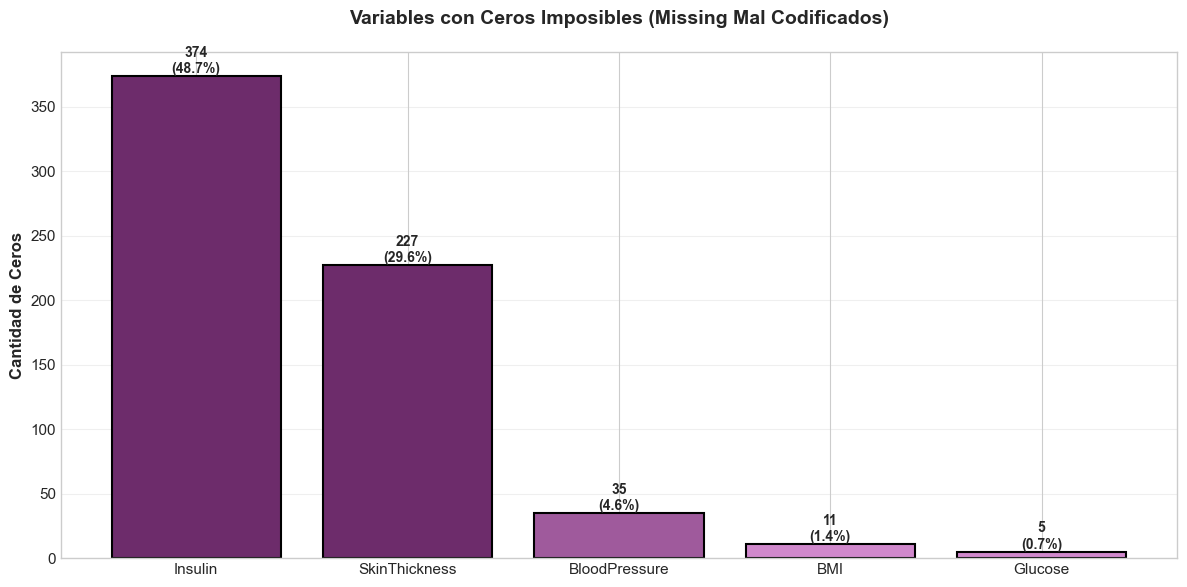


Gráfico guardado: ..\reports\figures\03_zeros_analysis.png


In [9]:
print("ANÁLIS DETALLADO DE VALORES CERO (BIOLÓGICAMENTE IMPOSIBLES)")

cannot_be_zero = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

zero_analysis = []
for col in cannot_be_zero:
    zeros = (df[col] == 0 ).sum()
    pct = (zeros / len(df) * 100)

    # Estadisticas sin los ceros
    data_sin_ceros = df[df[col] > 0][col]

    zero_analysis.append({
        'Variable':col,
        'Ceros':zeros,
        '% Ceros':pct,
        'Min (sin ceros)': data_sin_ceros.min() if len(data_sin_ceros) > 0 else np.nan,
        'Media (sin ceros)': data_sin_ceros.mean() if len(data_sin_ceros) > 0 else np.nan,
        'Mediana (sin ceros)': data_sin_ceros.median() if len(data_sin_ceros) > 0 else np.nan
    })

df_zeros = pd.DataFrame(zero_analysis).sort_values('Ceros', ascending=False)
display(df_zeros.style.background_gradient(subset=['Ceros', '% Ceros'], cmap='Reds'))

print('\nRESUMEN')
total_ceros = df_zeros['Ceros'].sum()
print(f'Total de ceros problemáticos: {total_ceros:,}')
print(f'Registros afectados: {df[cannot_be_zero].isin([0]).any(axis=1).sum()}' f'({df[cannot_be_zero].isin([0]).any(axis=1).sum()/len(df)*100:.1f}%)')


# Visualizar 

fig, ax = plt.subplots(figsize=(12,6))
colors = ['#6d2c6b' if x > 100 else '#9f5a9c' if x > 30 else '#d088cc' for x in df_zeros['Ceros']]
bars = ax.bar(df_zeros['Variable'], df_zeros['Ceros'], color=colors, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Cantidad de Ceros', fontsize=12, fontweight='bold')
ax.set_title('Variables con Ceros Imposibles (Missing Mal Codificados)', 
            fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

# Agregar porcentajes en las barras 
for bar, pct in zip(bars, df_zeros['% Ceros']):
    height= bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{int(height)}\n({pct:.1f}%)',
           ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.xticks(ha='center')
plt.tight_layout()
plt.savefig(FIGURES_DIR / '03_zeros_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nGráfico guardado: {FIGURES_DIR / '03_zeros_analysis.png'}")

### INSIGHT CRÍTICO

**Problema identificado:**
- **Insulin:** 374 ceros (48.7%) - SEVERIDAD ALTA
- **SkinThickness:** 227 ceros (29.6) - SEVERIDAD ALTA
- **BloodPressure:** 35 ceros (4.6%) - SEVERIDAD MEDIA
- **BMI:** 11 ceros (1.4%) - SEVERIDAD BAJA
- **Glucose:** 5 ceros (0.7) - SEVERIDAD BAJA

**¿Por qué son problemáticos?**
1. No son verdaderos ceros (nadie tiene 0 mg/dL de glucosa y está vivo)
2. Son **valores faltantes mal codificados** en la recolección de datos
3. Distorsionan estadísticas (media, desviación estándar)
4. Confunden a los modelos ML

**Decisión:** Reemplazar TODOS estos ceros por NaN para tratarlos como missing values

## Reemplazo de Ceros por NaN {#reeplazo}

In [11]:
print('REEMPLAZO DE CEROS IMPOSIBLES POR NaN')

# Crear copia antes de modificar
df_before = df.copy()

# Reemplazar ceros por NaN en variables específicas
for col in cannot_be_zero:
    ceros_antes = (df[col] == 0).sum()
    df.loc[df[col] == 0, col] = np.nan
    nans_despues = df[col].isna().sum()
    print(f"  • {col:20s}: {ceros_antes} ceros → {nans_despues} NaN")

print("\nReemplazo completado")


REEMPLAZO DE CEROS IMPOSIBLES POR NaN
  • Glucose             : 5 ceros → 5 NaN
  • BloodPressure       : 35 ceros → 35 NaN
  • SkinThickness       : 227 ceros → 227 NaN
  • Insulin             : 374 ceros → 374 NaN
  • BMI                 : 11 ceros → 11 NaN

Reemplazo completado
